# Prospecting LA's Backyard Houses with Machine Learning
  
  
## Anupama Garla  


## Nightly Price Predictions for Backyard Houses

In [6]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set()

#plotting
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline

#preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

from statistics import mean

pd.set_option('display.max_row', 1000)
pd.set_option('display.max_column', 100)

#get pandas and sql to work together
import psycopg2 as pg
import pandas.io.sql as pd_sql
from psycopg2 import connect
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

#get distances between coordinates
from geopy.distance import geodesic
import numpy as np

from sklearn.externals import joblib


from Backyard_House_Helper_Functions import geo_data_amenity_count_func, geo_data_dist_func

/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## 4.0 Pull in AirBnB Data to look at reducing features for an mvp prediction

In [6]:
#Connect to sql database
params = {
    'host': 'localhost',  # connecting to _local_ version of psql
    'user': 'agar',
    'dbname': 'properties',    # DB connecting to
    'port': 5432          # port
}

# make connection by unpacking params
connection = pg.connect(**params)

In [7]:
#Pull target and features from AirBnB sql table
#Get only superhost properties
#Get relevant amenities and location information
#Limit review scores to content-based on property and check-in ease
query_airbnb_edited = """
select cast(regexp_replace(price, '\$|\.00|,', '','g') as int) as price, al.reviews_per_month, al.accommodates, al.bedrooms, al.bathrooms, al.beds, al.availability_365, 
al.review_scores_checkin, al.review_scores_cleanliness, al.review_scores_communication, 
al.review_scores_location, al.review_scores_value, al.property_type, al."latitude", al."longitude", 
regexp_replace(al."neighbourhood", '\ |\-|\/,', '_','g') as "neighborhood",

(count(al."neighbourhood") over
(PARTITION BY al."neighbourhood", al."bedrooms"))
         AS neigh_br_competition,
         
(case when al.amenities like '%Dishwasher%' then 1 else 0 end) as "dishwasher",
(case when al.amenities like '%Garden or backyard%' then 1 else 0 end) as "yard",
(case when al.amenities like '%Patio or balcony%' then 1 else 0 end) as "patio",
(case when al.amenities like '%Self check-in%' then 1 else 0 end) as "check_in_self",
(case when al.amenities like '%parking%' then 1 else 0 end) as "parking",
(case when al.amenities like '%pool%' then 1 else 0 end) as "pool",
(case when al.amenities like '%Long term%' then 1 else 0 end) as "long_term",
(case when al.amenities like '%Baby%' then 1 else 0 end) as "baby",
(case when al.amenities like '%Child%' then 1 else 0 end) as "children",
(case when al.amenities like '%Family%' then 1 else 0 end) as "family",
(case when al.amenities like '%24-hour%' then 1 else 0 end) as "check_in_24hrs",
al."amenities",
(case when al.amenities like '%Washer%' then 1 else 0 end) as "washer_dryer",
(case when al.amenities like '%Air conditioning%' then 1 else 0 end) as "air_con",
(case when al.amenities like '%Heating%' then 1 else 0 end) as "heating",
(case when al.amenities like '%Pets%' then 1 else 0 end) as "pets",
(case when al.amenities like '%Lockbox%' then 1 else 0 end) as "lockbox"

from airbnb_full_listings al
where room_type = 'Entire home/apt' and al.host_is_superhost = 't' and cast(regexp_replace(price, '\$|\.00|,', '','g') as int)<1000 and cast(regexp_replace(price, '\$|\.00|,', '','g') as int)>20
"""

In [8]:
#Pull x target and y features into DataFrame from sql
airbnb_df = pd.read_sql_query(query_airbnb_edited , connection, index_col=None, coerce_float=True, params=None, parse_dates=None, chunksize=None)
airbnb_df.columns

Index(['price', 'reviews_per_month', 'accommodates', 'bedrooms', 'bathrooms',
       'beds', 'availability_365', 'review_scores_checkin',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'property_type',
       'latitude', 'longitude', 'neighborhood', 'neigh_br_competition',
       'dishwasher', 'yard', 'patio', 'check_in_self', 'parking', 'pool',
       'long_term', 'baby', 'children', 'family', 'check_in_24hrs',
       'amenities', 'washer_dryer', 'air_con', 'heating', 'pets', 'lockbox'],
      dtype='object')

In [9]:
#Look at head
airbnb_df.head(20)

,price,reviews_per_month,accommodates,bedrooms,bathrooms,beds,availability_365,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_value,property_type,latitude,longitude,neighborhood,neigh_br_competition,dishwasher,yard,patio,check_in_self,parking,pool,long_term,baby,children,family,check_in_24hrs,amenities,washer_dryer,air_con,heating,pets,lockbox
0,90,3.58,2,0.0,1.0,1.0,61,10.0,10.0,10.0,10.0,10.0,Guesthouse,34.08812,-118.13703,Alhambra,2,0,1,1,0,1,0,0,0,0,0,0,"{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...",0,1,1,0,0
1,80,2.42,5,0.0,1.0,2.0,348,10.0,10.0,10.0,10.0,10.0,Guesthouse,34.08158,-118.13425,Alhambra,2,0,1,0,1,1,0,0,0,0,0,0,"{TV,Wifi,""Air conditioning"",Pool,Kitchen,""Free...",0,1,1,1,1
2,65,7.00,4,1.0,1.5,2.0,269,10.0,10.0,10.0,10.0,10.0,House,34.08533,-118.12938,Alhambra,27,0,0,0,0,0,0,0,0,0,0,0,"{TV,Wifi,""Air conditioning"",Kitchen,""Pets allo...",1,1,1,1,0
3,73,6.03,3,1.0,1.0,1.0,3,10.0,10.0,10.0,9.0,9.0,Condominium,34.09559,-118.13504,Alhambra,27,1,0,0,1,1,0,0,0,0,0,0,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",1,1,1,0,0
4,89,0.59,4,1.0,1.0,2.0,60,10.0,10.0,10.0,10.0,10.0,Condominium,34.08646,-118.12434,Alhambra,27,0,0,0,1,1,0,1,1,0,0,0,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",1,1,0,0,0
5,49,0.40,2,1.0,1.0,2.0,176,10.0,10.0,10.0,10.0,10.0,Condominium,34.10044,-118.12677,Alhambra,27,1,0,0,1,1,0,1,0,0,1,0,"{TV,Wifi,""Air conditioning"",""Free parking on p...",1,1,1,0,0
6,95,4.41,7,1.0,1.0,4.0,117,10.0,9.0,10.0,10.0,9.0,Condominium,34.09895,-118.12594,Alhambra,27,1,0,0,1,1,0,1,0,0,1,0,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",1,1,1,0,0
7,153,3.15,8,1.0,1.0,4.0,333,10.0,10.0,10.0,10.0,10.0,Condominium,34.10062,-118.12553,Alhambra,27,1,0,0,1,1,0,1,0,0,1,0,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",1,1,1,0,0
8,79,2.36,4,1.0,1.0,2.0,33,10.0,10.0,10.0,9.0,10.0,Condominium,34.08664,-118.12315,Alhambra,27,0,0,0,1,1,0,1,1,0,0,0,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",1,1,1,0,0
9,89,2.56,3,1.0,1.0,2.0,145,10.0,10.0,10.0,10.0,10.0,Apartment,34.08578,-118.12278,Alhambra,27,0,0,0,1,1,0,1,1,0,0,0,"{TV,Wifi,""Air conditioning"",Kitchen,""Free park...",1,1,1,0,0


### Best Model for comparison

In [10]:
#Create target and feature DataFrames
#Create X target dataframe from 'price'
#Create y feature dataframe from all other columns

X = airbnb_df.iloc[:, 1:]

y = airbnb_df.iloc[:, 0]

#Create lists to store cross-val scores for each metric in a list
# perform train/test split, get dummies for string-type features
X_train, X_test, y_train, y_test = \
    train_test_split(pd.get_dummies(X), y, test_size=0.2, random_state=42)

# Create 5-fold Cross Validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
kf.get_n_splits(X_train)
rmse_list = []
mae_list = []
r2_list = []

#Run model on each kfold split and record scores 
for train_ind, val_ind in kf.split(X_train):
    
    #assign train and validate sets
    X_tr, y_tr = X_train.iloc[train_ind], y_train.iloc[train_ind]
    X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
    
    #fit model
    xgb_model = xgb.XGBRegressor()
    xgb_model.fit(X_tr, y_tr)
    
    # score fit model on validation data
    xgb_preds = xgb_model.predict(X_val)
    
    val_score = xgb_model.score(X_val, y_val)
    rmse = np.sqrt(metrics.mean_squared_error(y_val,xgb_preds))
    mae = metrics.mean_absolute_error(y_val, xgb_preds)
    
    r2_list.append(val_score)
    rmse_list.append(rmse)
    mae_list.append(mae)

print("rmse cv avg: ", mean(rmse_list))
print("mae cv avg: ", mean(mae_list))
print("val cv avg: ", mean(r2_list))

/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:57:23] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:00:18] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:03:15] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:06:14] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:09:02] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse cv avg:  84.02396739167455
mae cv avg:  51.75642701933216
val cv avg:  0.6550087425614515


In [11]:
pd.set_option('display.max_column', 10)
X_tr.transpose().head(100)

,7939,100,5769,4814,8195,...,5734,5191,5390,860,7270
reviews_per_month,NaN,1.65000,1.25000,1.69000,0.05000,...,6.24000,0.39000,NaN,1.78000,1.44000
accommodates,4.00000,2.00000,6.00000,4.00000,12.00000,...,5.00000,2.00000,4.00000,5.00000,4.00000
bedrooms,1.00000,1.00000,3.00000,2.00000,4.00000,...,2.00000,1.00000,2.00000,2.00000,1.00000
bathrooms,2.00000,1.00000,1.50000,1.00000,3.00000,...,1.00000,1.00000,1.00000,1.50000,1.00000
beds,1.00000,1.00000,3.00000,3.00000,5.00000,...,2.00000,1.00000,2.00000,3.00000,1.00000
availability_365,324.00000,103.00000,64.00000,207.00000,175.00000,...,277.00000,322.00000,180.00000,223.00000,134.00000
review_scores_checkin,NaN,10.00000,10.00000,10.00000,10.00000,...,10.00000,10.00000,NaN,10.00000,9.00000
review_scores_cleanliness,NaN,9.00000,10.00000,10.00000,10.00000,...,10.00000,10.00000,NaN,10.00000,10.00000
review_scores_communication,NaN,10.00000,10.00000,10.00000,10.00000,...,10.00000,10.00000,NaN,10.00000,10.00000
review_scores_location,NaN,10.00000,10.00000,10.00000,9.00000,...,10.00000,10.00000,NaN,10.00000,10.00000


In [339]:
X.columns

Index(['reviews_per_month', 'accommodates', 'bedrooms', 'bathrooms', 'beds',
       'availability_365', 'review_scores_checkin',
       'review_scores_cleanliness', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'property_type',
       'latitude', 'longitude', 'neighborhood', 'neigh_br_competition',
       'dishwasher', 'yard', 'patio', 'check_in_self', 'parking', 'pool',
       'long_term', 'baby', 'children', 'family', 'check_in_24hrs',
       'washer_dryer', 'air_con', 'heating', 'pets', 'lockbox', 'lat_lon',
       'nearest_sales_price', 'arts_rec_count', 'arts_theater_count',
       'comfort_vs_capacity', 'parks_one_mi', 'parks_four_mi', 'uni_two_mi',
       'transport_airports_ten_mi', 'transport_freeway_two_mi',
       'transport_metro_one_mi', 'transport_metro_two_mi',
       'transport_convenience', 'rarity_per_pricey_hood',
       'longitude_scaled_pos', 'rarity_property',
       'nearest_sales_price_squared', 'amenities_convenience'],


In [340]:
# Save the model as a pickle in a file 
joblib.dump(xgb_model, 'xgb_model_sun.pkl') 

['xgb_model_sun.pkl']

In [132]:
print(mae_list)

[51.933369971806115, 52.160579128164, 52.00801329152912, 52.853233766085104, 49.19657202208685]


### Look at model performance with minimum features

In [20]:
simplified_airbnb_df = airbnb_df.loc[:,["price", 'bedrooms', 'bathrooms', 
       'latitude', 'longitude']]

simplified_airbnb_df_2 = airbnb_df.loc[:,["price", 'accommodates', 'bedrooms', 'bathrooms', 
       'latitude', 'longitude']]

In [17]:
airbnb_df.loc[:,["price", 'bedrooms', 'bathrooms', 
       'latitude', 'longitude']]

,price,bedrooms,bathrooms,latitude,longitude
0,90,0.0,1.0,34.08812,-118.13703
1,80,0.0,1.0,34.08158,-118.13425
2,65,1.0,1.5,34.08533,-118.12938
3,73,1.0,1.0,34.09559,-118.13504
4,89,1.0,1.0,34.08646,-118.12434
...,...,...,...,...,...
8227,599,7.0,4.0,33.99325,-117.94918
8228,459,7.0,7.5,33.98486,-117.91145
8229,419,8.0,7.5,33.98879,-117.85597
8230,750,9.0,8.5,33.97611,-117.86764


In [55]:
#Create target and feature DataFrames
#Create X target dataframe from 'price'
#Create y feature dataframe from all other columns

X = simplified_airbnb_df.iloc[:, 1:]

y = simplified_airbnb_df.iloc[:, 0]

#Create lists to store cross-val scores for each metric in a list
# perform train/test split, get dummies for string-type features
X_train, X_test, y_train, y_test = \
    train_test_split(pd.get_dummies(X), y, test_size=0.2, random_state=42)

# Create 5-fold Cross Validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
kf.get_n_splits(X_train)
rmse_list = []
mae_list = []
r2_list = []

#Run model on each kfold split and record scores 
for train_ind, val_ind in kf.split(X_train):
    
    #assign train and validate sets
    X_tr, y_tr = X_train.iloc[train_ind], y_train.iloc[train_ind]
    X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
    
    #fit model
    xgb_model = xgb.XGBRegressor()
    xgb_model.fit(X_tr, y_tr)
    
    # score fit model on validation data
    xgb_preds = xgb_model.predict(X_val)
    
    val_score = xgb_model.score(X_val, y_val)
    rmse = np.sqrt(metrics.mean_squared_error(y_val,xgb_preds))
    mae = metrics.mean_absolute_error(y_val, xgb_preds)
    
    r2_list.append(val_score)
    rmse_list.append(rmse)
    mae_list.append(mae)

print("rmse cv avg: ", mean(rmse_list))
print("mae cv avg: ", mean(mae_list))
print("val cv avg: ", mean(r2_list))

/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:22:50] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:22:50] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:22:50] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:22:51] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:22:51] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse cv avg:  89.16325625591524
mae cv avg:  55.20444291099601
val cv avg:  0.6115559292085411


In [21]:
#Create target and feature DataFrames
#Create X target dataframe from 'price'
#Create y feature dataframe from all other columns

X = simplified_airbnb_df_2.iloc[:, 1:]

y = simplified_airbnb_df_2.iloc[:, 0]

#Create lists to store cross-val scores for each metric in a list
# perform train/test split, get dummies for string-type features
X_train, X_test, y_train, y_test = \
    train_test_split(pd.get_dummies(X), y, test_size=0.2, random_state=42)

# Create 5-fold Cross Validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)
kf.get_n_splits(X_train)
rmse_list = []
mae_list = []
r2_list = []

#Run model on each kfold split and record scores 
for train_ind, val_ind in kf.split(X_train):
    
    #assign train and validate sets
    X_tr, y_tr = X_train.iloc[train_ind], y_train.iloc[train_ind]
    X_val, y_val = X_train.iloc[val_ind], y_train.iloc[val_ind]
    
    #fit model
    xgb_model = xgb.XGBRegressor()
    xgb_model.fit(X_tr, y_tr)
    
    # score fit model on validation data
    xgb_preds = xgb_model.predict(X_val)
    
    val_score = xgb_model.score(X_val, y_val)
    rmse = np.sqrt(metrics.mean_squared_error(y_val,xgb_preds))
    mae = metrics.mean_absolute_error(y_val, xgb_preds)
    
    r2_list.append(val_score)
    rmse_list.append(rmse)
    mae_list.append(mae)

print("rmse cv avg: ", mean(rmse_list))
print("mae cv avg: ", mean(mae_list))
print("val cv avg: ", mean(r2_list))

/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:32:14] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:32:15] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:32:15] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:32:15] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/Users/agar/opt/anaconda3/envs/metis/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:32:16] WARNING: /usr/local/miniconda/conda-bld/xgboost_1572315027083/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse cv avg:  87.56371711806665
mae cv avg:  54.189371856596765
val cv avg:  0.6253426295342132


In [22]:
#apply model to test set, get scores

xgb_preds = xgb_model.predict(X_test)
    
val_score = xgb_model.score(X_test, y_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test,xgb_preds))
mae = metrics.mean_absolute_error(y_test, xgb_preds)

print("rmse : ", rmse)
print("mae : ", mae)
print("val : ", val_score)

rmse :  90.48505242308774
mae :  55.54708293921743
val :  0.602346461768167


### 4.2 Run AirBnB price prediction model on Backyard House Lot Data

### Look at Backyard House Lot Data

In [35]:
house_2 = pd.read_csv("adu_sun_calc_df.csv")
house_2.head()

,Unnamed: 0,ShapeSTArea,void,SQFTmain,SitusFullAddress,...,APN,CENTER_LAT,CENTER_LON,Location 1,adu_br
0,1,41704.123047,38040.123047,3664,1070 CASIANO RD LOS ANGELES CA 90049,...,4368-011-041,34.079679,-118.469282,"(34.07967865, -118.46928191)",3
1,2,71339.170898,70179.170898,1160,13045 W PACIFIC PROMENADE 318 PLAYA VISTA CA 9...,...,4211-032-193,33.972902,-118.424457,"(33.97290243, -118.42445729)",1
2,3,29901.567383,28059.567383,1842,23445 BALMORAL LN LOS ANGELES CA 91307,...,2028-019-016,34.197978,-118.637806,"(34.1979776, -118.63780609)",2
3,4,6648.419922,5168.419922,1480,7827 MCGROARTY ST LOS ANGELES CA 91040,...,2559-026-010,34.252607,-118.303697,"(34.25260673, -118.3036971)",2
4,5,7650.847656,6556.847656,1094,3918 W CHANDLER BLVD BURBANK CA 91505,...,2476-023-001,34.170151,-118.351311,"(34.17015138, -118.35131147)",1


In [39]:
house_2.columns

Index(['Unnamed: 0', 'ShapeSTArea', 'void', 'SQFTmain', 'SitusFullAddress',
       'AIN', 'ShapeSTLength', 'APN', 'CENTER_LAT', 'CENTER_LON', 'Location 1',
       'adu_br'],
      dtype='object')

### Edit Backyard House Dataset to MVP features for modelling

In [54]:
simplify_house_df = house_2.loc[:,['SitusFullAddress', 'adu_br', 'CENTER_LAT', 'CENTER_LON']]
simplify_house_df.head()

,address,bedrooms,latitude,longitude,bathrooms,house_area
0,1070 CASIANO RD LOS ANGELES CA 90049,3,34.079679,-118.469282,2,1200
1,13045 W PACIFIC PROMENADE 318 PLAYA VISTA CA 9...,1,33.972902,-118.424457,1,400
2,23445 BALMORAL LN LOS ANGELES CA 91307,2,34.197978,-118.637806,1,700
3,7827 MCGROARTY ST LOS ANGELES CA 91040,2,34.252607,-118.303697,1,700
4,3918 W CHANDLER BLVD BURBANK CA 91505,1,34.170151,-118.351311,1,400


### Rename Features

In [43]:
simplify_house_df.columns = ['address', 'bedrooms', 'latitude', 'longitude']

### Create Bathrooms feature for modeling and web app

In [50]:
def bathroom_count(bedrooms):
    """ (float, float) -> int

    Return 2, or 1 indicating the number of bathrooms a backyard house could have
    based on the number of bedrooms.
    """
    if bedrooms == 3:
        bathrooms = 2
    else:
        bathrooms = 1
    return bathrooms

In [51]:
#apply bathroom function to Lot DataFrame
simplify_house_df["bathrooms"] =  simplify_house_df.apply(lambda x: bathroom_count(x.bedrooms), axis=1)

### Create area Feature for web app

In [48]:
def house_area(bedrooms):
    """ (int) -> int

    Return the typical backyard house area for a 3 br
    is 1200 sf, 2 br is 700 sf, 1 br is 400 sf.

    """
    if bedrooms == 3:
        house_area = 1200
        return house_area
    elif bedrooms == 2:
        house_area = 700
        return house_area
    else:
        house_area = 400
    return house_area

In [53]:
#apply house area function to Lot DataFrame
simplify_house_df["house_area"] =  simplify_house_df.apply(lambda x: house_area(x.bedrooms), axis=1)

In [58]:
simplify_house_df.columns

Index(['address', 'bedrooms', 'latitude', 'longitude', 'bathrooms',
       'house_area'],
      dtype='object')

### Create X matrix for predicting price

In [60]:
X_df = simplify_house_df[['bedrooms', 'bathrooms', 
       'latitude', 'longitude']]
X_df.head()

,bedrooms,bathrooms,latitude,longitude
0,3,2,34.079679,-118.469282
1,1,1,33.972902,-118.424457
2,2,1,34.197978,-118.637806
3,2,1,34.252607,-118.303697
4,1,1,34.170151,-118.351311


### Apply price prediction model to test set

In [91]:
xgb_preds = xgb_model.predict(X_df)
    
simplify_house_df["predicted_income"] = xgb_preds
simplify_house_df.head()

,address,bedrooms,latitude,longitude,bathrooms,house_area,predicted_income
0,1070 CASIANO RD LOS ANGELES CA 90049,3,34.079679,-118.469282,2,1200,331.755798
1,13045 W PACIFIC PROMENADE 318 PLAYA VISTA CA 9...,1,33.972902,-118.424457,1,400,131.782166
2,23445 BALMORAL LN LOS ANGELES CA 91307,2,34.197978,-118.637806,1,700,182.174545
3,7827 MCGROARTY ST LOS ANGELES CA 91040,2,34.252607,-118.303697,1,700,124.051247
4,3918 W CHANDLER BLVD BURBANK CA 91505,1,34.170151,-118.351311,1,400,112.841637


### Examine Results

In [63]:
simplify_house_df.describe()

,bedrooms,latitude,longitude,bathrooms,house_area,predicted_income
count,1.597449e+06,1.597351e+06,1.597351e+06,1.597449e+06,1.597449e+06,1.597449e+06
mean,1.658685e+00,3.409138e+01,-1.182434e+02,1.106266e+00,6.188588e+02,1.394486e+02
std,6.613259e-01,2.024019e-01,2.206611e-01,3.081783e-01,2.454894e+02,5.917882e+01
min,1.000000e+00,3.333529e+01,-1.189390e+02,1.000000e+00,4.000000e+02,7.125415e+01
25%,1.000000e+00,3.395486e+01,-1.184104e+02,1.000000e+00,4.000000e+02,1.003354e+02
50%,2.000000e+00,3.407520e+01,-1.182563e+02,1.000000e+00,7.000000e+02,1.240512e+02
75%,2.000000e+00,3.418233e+01,-1.180938e+02,1.000000e+00,7.000000e+02,1.549504e+02
max,3.000000e+00,3.481966e+01,-1.176524e+02,2.000000e+00,1.200000e+03,1.172530e+03


In [65]:
simplify_house_df.to_csv("backyard_house_predicted_income.csv")

### Round predicted income and classify income segment based on distribution

In [105]:
rounded_income = simplify_house_df.round({"predicted_income":0}) 
rounded_income["predicted_income"] = rounded_income.predicted_income.astype(int)
rounded_income.head()

,address,bedrooms,latitude,longitude,bathrooms,house_area,predicted_income,income_segment
0,1070 CASIANO RD LOS ANGELES CA 90049,3,34.079679,-118.469282,2,1200,332,high
1,13045 W PACIFIC PROMENADE 318 PLAYA VISTA CA 9...,1,33.972902,-118.424457,1,400,132,medium
2,23445 BALMORAL LN LOS ANGELES CA 91307,2,34.197978,-118.637806,1,700,182,high
3,7827 MCGROARTY ST LOS ANGELES CA 91040,2,34.252607,-118.303697,1,700,124,medium
4,3918 W CHANDLER BLVD BURBANK CA 91505,1,34.170151,-118.351311,1,400,113,medium


In [102]:
rounded_income.predicted_income.quantile(0.25)

100.0

In [101]:
rounded_income.predicted_income.quantile(0.75)

155.0

In [103]:
def income_category(predicted_income):
    """ (int) -> string

    Return low, medium, or high for given income predictions.

    """
    if predicted_income >= 155:
        income_segment = "high"
        return income_segment
    elif predicted_income >= 100:
        income_segment = "medium"
        return income_segment
    else:
        income_segment = "low"
    return income_segment

In [104]:
#apply income_segment function to Lot DataFrame
rounded_income["income_segment"] =  rounded_income.apply(lambda x: income_category(x.predicted_income), axis=1)

rounded_income.to_csv("backyard_house_income_segmentation.csv")

In [3]:
df = pd.read_csv("backyard_house_income_segmentation.csv")

df.head()

,Unnamed: 0,address,bedrooms,latitude,longitude,bathrooms,house_area,predicted_income,income_segment
0,0,1070 CASIANO RD LOS ANGELES CA 90049,3,34.079679,-118.469282,2,1200,332,high
1,1,13045 W PACIFIC PROMENADE 318 PLAYA VISTA CA 9...,1,33.972902,-118.424457,1,400,132,medium
2,2,23445 BALMORAL LN LOS ANGELES CA 91307,2,34.197978,-118.637806,1,700,182,high
3,3,7827 MCGROARTY ST LOS ANGELES CA 91040,2,34.252607,-118.303697,1,700,124,medium
4,4,3918 W CHANDLER BLVD BURBANK CA 91505,1,34.170151,-118.351311,1,400,113,medium


### prep look-up function for web app

In [8]:
#get user address input
user_input = "1070 CASIANO RD LOS ANGELES CA 90049"

#mask dataframe row to user_input address
mask = df["address"] == user_input

#create new dataframe from mask
info = df[mask]

if info.shape[0] == 0:
    print("not good addy")
    
#create list from masked dataframe
prop_info = list(info.iloc[0])

#extract user output from list
#bedrooms
br = prop_info[2]

#baths
ba = prop_info[5]

#square feet
sf = prop_info[6]

#nightly price/income
price = prop_info[7]

#LA segment
segment = prop_info[8]

#create tuple to use in string
test_tuple = (price, segment, sf, br, ba)

#print output
print ("""Your nightly income prediction is $%d which is in the %s income segment for Los Angeles.\n
Your property can accomodate a %d square foot backyard house. \n
This is typically a %d bedroom , %d bath unit. \n""" % test_tuple
      )

Your nightly income prediction is $332 which is in the high income segment for Los Angeles.

Your property can accomodate a 1200 square foot backyard house. 

This is typically a 3 bedroom , 2 bath unit. 



### a quick look at the distribution of nightly incomes in this iteration

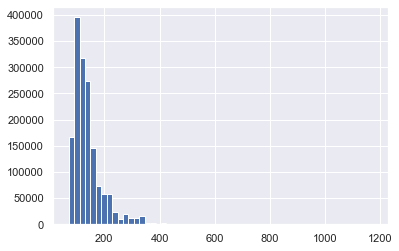

In [13]:
import math

data = df["predicted_income"]
w = 20
n = math.ceil((data.max() - data.min())/w)
ax = plt.hist(data, bins = n)

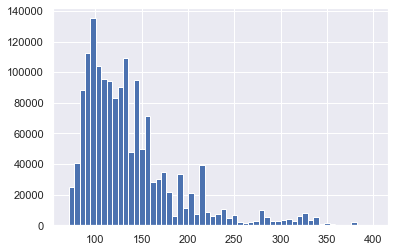

In [15]:
# editing out the right tail
n = math.ceil((data.max() - data.min())/w)
ax = plt.hist(data, range = (data.min(), 400), bins = n)